# Exercise 0-3 : Finite size scaling of the 2d Ising model 
2019, May, Tsuyoshi Okubo  
2020, July, Tsuyoshi Okubo  
2021, July, Tsuyoshi Okubo  
2023, March, Tsuyoshi Okubo

This code simulate 2d Ising model on the square lattice, whose Hamiltonian is given by
$$ \mathcal{H} = -J \sum_{\langle i,j\rangle} S_i S_j - h \sum_i S_i ,$$
where $S_i = \pm 1$.

You can select three simulation algorithms:
* metropolis
* heatbath
* cluster (Swendsen-Wang)

The main outputs are:
* Energy: $\langle E\rangle = \langle \mathcal{H}\rangle/N$.
* Squared magnetization: $\langle M^2\rangle = \langle (\sum_i S_i)^2\rangle/N^2$.
* Specific heat: $N(\langle E^2\rangle - \langle E\rangle^2)/T$
* Magnetic susceptibility: $N(\langle M^2\rangle)/T$ 
* Connected susceptibility: $N(\langle M^2\rangle - \langle |M|\rangle^2)/T$ 
* Binder ratio: $(\langle M^4\rangle/\langle M^2\rangle^2)/T$

The code will make graphs of 
* Energy
* Specific heat
* Squared magnetization 
* Binder ratio
as functions of the temperature for various system sizes $L$.

You will perform Finite size scaling for these observables.

#### Parameters for MC simulations
* themalizatoin: MC steps for thermalization, which is not used for calculating expectation values.
* observation: MC steps for observation, which is used for calculating expectation values.
* random_seed: Seed for random numbser generator. For the same random_seed, you always obtain the same result.

#### Parameters for the finite size scaling
* Tc_est
* nu
* eta  

These parameters are set after the simulations.
When you repeat finite size scaling using the same simulation data, please run only after the simulation part.
Instead, you may load simulation data, by setting "Read_simulation_data" is True.

#### Important notice
* This code works on python3 with numpy and numba modules.

In [1]:
import numpy as np
import pickle
try:
    from Ising_lib import *
except ImportError:
    !wget https://raw.githubusercontent.com/TsuyoshiOkubo/Introduction-to-Tensor-Network/main/Exercise/Ising_lib.py
    from Ising_lib import *
%matplotlib inline
from matplotlib import pyplot


In [2]:
Tc = 2.0/np.log(1.0+np.sqrt(2.0)) ## The critical temperature of the Ising model 

Read_simulation_data = False ## If you have already performed MC simulation and just do finite size scaling set True and set data file.
data_file = "mcdata_ex0-3.dat" ## If Read_simulation_dat is True, simulation data will be read from this file. Otherwise, simulation data will be seved to this file.


#Parameters for calculation
L_list=[8,16,32,64]
T_list=np.arange(2.2,2.35,0.005) ## T_min = 2.2, T_max = 2.35, T_step = 0.005
T_list_all = []
for L in L_list:
    T_list_all.append(T_list)
## You may prepare different temperature set depending on L

h = 0 ## Within this excersize, h =0 always. 


algorithm="metropolis"
#algorithm="heatbath"
#algorithm = "cluster"

random_seed = None #11

if random_seed is not None:
    np.random.seed(random_seed)
random_seed_list_all = []
for i in range(len(L_list)):
    random_seed_list_all.append(np.random.randint(2**31,size=len(T_list_all[i])))

thermalization = 10000
observation = 50000

thermalization_list = []
observation_list = []
for L in L_list:
    thermalization_list.append(thermalization)
    observation_list.append(observation)
## You may prepare different thermalization and observation depending on L



In [3]:
def Calc_averages(mag, mag2, mag2_imp, mag4, mag_abs, ene,ene2, L,T,alogorithm):

    def variance(e,e2):
        return e2 -e**2
    def binder(m2,m4):
        return m4 / m2 **2

    observation = len(ene)
    N = L**2

    e, e_err = Jackknife(ene,bin_size=max(100,observation//100))
    e2,e2_err = Jackknife(ene2,bin_size=max(100,observation//100))
    m,m_err = Jackknife(mag,bin_size=max(100,observation//100))
    m2,m2_err = Jackknife(mag2,bin_size=max(100,observation//100))
    m4,m4_err = Jackknife(mag4,bin_size=max(100,observation//100))
    c, c_err = Jackknife(ene,bin_size=max(100,observation//100),func=variance, data2=ene2)
    c *= N/T**2
    c_err *= N/T**2
    b, b_err = Jackknife(mag2,bin_size=max(100,observation//100),func=binder, data2=mag4)
    chi, chi_err = Jackknife(mag_abs,bin_size=max(100,observation//100),func=variance, data2=mag2)
    
    chi *= N/T
    chi_err *= N/T
    
    if algorithm == "cluster":
        m2_imp, m2_imp_err = Jackknife(mag2_imp,bin_size=max(100,observation//100))
    else:
        m2_imp = 0.0
        m2_imp_err = 0.0
    return e, e_err, m2, m2_err, c, c_err, b,b_err,chi, chi_err,m2_imp, m2_imp_err

In [4]:
%%time
if Read_simulation_data:
    f = open(data_file,"rb")
    obs_list_all = pickle.load(f)
    f.close

    Ene_all = obs_list_all[0]
    Ene_err_all = obs_list_all[1]
    Mag2_all = obs_list_all[2]
    Mag2_err_all = obs_list_all[3]
    Mag2_imp_all = obs_list_all[4]
    Mag2_imp_err_all = obs_list_all[5]

    Binder_all = obs_list_all[6]
    Binder_err_all = obs_list_all[7]
    C_all = obs_list_all[8]
    C_err_all = obs_list_all[9]
    Chi_all = obs_list_all[10]
    Chi_err_all = obs_list_all[11]
    
    L_list = obs_list_all[12]
    T_list_all = obs_list_all[13]
else:
    ## run simulation

    Ene_all = []
    Ene_err_all = []
    Mag2_all = []
    Mag2_err_all = []
    Mag2_imp_all = []
    Mag2_imp_err_all = []


    Binder_all = []
    Binder_err_all = []
    C_all = []
    C_err_all = []
    Chi_all = []
    Chi_err_all = []
    
    for i in range(len(L_list)):
        L = L_list[i]
        Ene = []
        Ene_err = []
        Mag2 = []
        Mag2_err = []
        Binder = []
        Binder_err = []
        C = []
        C_err = []
        Mag2_imp = []
        Mag2_imp_err = []
        Chi = []
        Chi_err = []

        for j in range(len(T_list_all[i])):
            T = T_list_all[i][j]
            mag, mag2, mag2_imp, mag4, mag_abs, ene,ene2 = MC(L,T,h,thermalization_list[i],observation_list[i],random_seed_list_all[i][j],algorithm)
            e, e_err, m2, m2_err, c, c_err, b,b_err,chi, chi_err,m2_imp, m2_imp_err = Calc_averages(mag, mag2, mag2_imp, mag4, mag_abs, ene,ene2, L,T,algorithm)

            Ene.append(e)
            Ene_err.append(e_err)

            Mag2.append(m2)
            Mag2_err.append(m2_err)

            C.append(c)
            C_err.append(c_err)

            Binder.append(b)
            Binder_err.append(b_err)
            
            Chi.append(chi)
            Chi_err.append(chi_err)

            Mag2_imp.append(m2_imp)
            Mag2_imp_err.append(m2_imp_err)

        Ene_all.append(Ene)
        Ene_err_all.append(Ene_err)
        Mag2_all.append(Mag2)
        Mag2_err_all.append(Mag2_err)
        Mag2_imp_all.append(Mag2_imp)
        Mag2_imp_err_all.append(Mag2_imp_err)


        Binder_all.append(Binder)
        Binder_err_all.append(Binder_err)
        C_all.append(C)
        C_err_all.append(C_err)
        Chi_all.append(Chi)
        Chi_err_all.append(Chi_err)

    ## save to data_file

    f = open(data_file,"wb")
    obs_list_all = [Ene_all,Ene_err_all,Mag2_all,Mag2_err_all,Mag2_imp_all,Mag2_imp_err_all,Binder_all,Binder_err_all,C_all,C_err_all,Chi_all,Chi_err_all,L_list,T_list_all]
    pickle.dump(obs_list_all,f)
    f.close

CPU times: user 3min 2s, sys: 1.07 s, total: 3min 3s
Wall time: 3min 4s


In the following, we perform the finite size scaling of simulation data:
* Energy
* Specific heat
* Squared Magnetization
* Binder ratio

Fisrt, we plot raw date witout scaling.

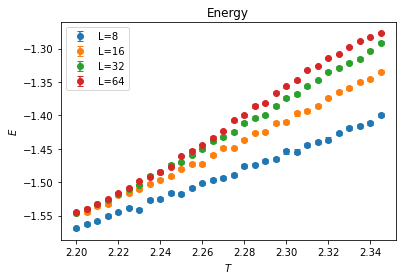

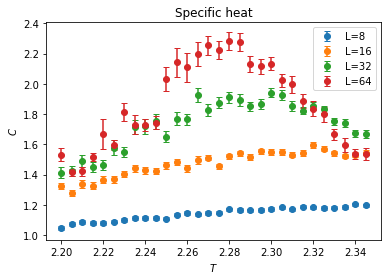

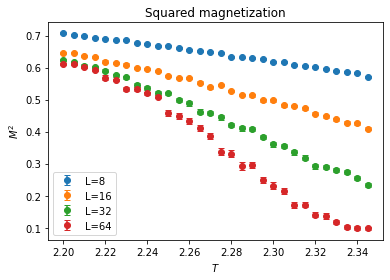

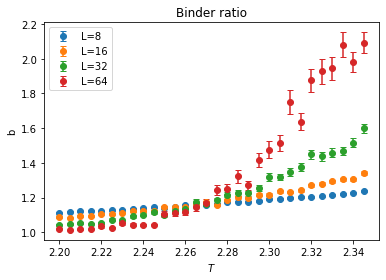

In [5]:
## plot observables
pyplot.figure()
pyplot.title("Energy")
pyplot.xlabel("$T$")
pyplot.ylabel("$E$")
for i in range(len(L_list)):
    pyplot.errorbar(T_list_all[i],Ene_all[i],yerr=np.array(Ene_err_all[i]),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
pyplot.legend()

pyplot.figure()
pyplot.title("Specific heat")
pyplot.xlabel("$T$")
pyplot.ylabel("$C$")
for i in range(len(L_list)):
    pyplot.errorbar(T_list_all[i],C_all[i],yerr=np.array(C_err_all[i]),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
pyplot.legend()

pyplot.figure()
pyplot.title("Squared magnetization")
pyplot.xlabel("$T$")
pyplot.ylabel("$M^2$")
for i in range(len(L_list)):
    pyplot.errorbar(T_list_all[i],Mag2_all[i],yerr=np.array(Mag2_err_all[i]),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
pyplot.legend()

if algorithm == "cluster":
    pyplot.figure()
    pyplot.title("Squared magnetization:improved")
    pyplot.xlabel("$T$")
    pyplot.ylabel("$M^2$")
    for i in range(len(L_list)):
        pyplot.errorbar(T_list_all[i],Mag2_all[i],yerr=np.array(Mag2_imp_err_all[i]),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
    pyplot.legend()

pyplot.figure()
pyplot.title("Binder ratio")
pyplot.xlabel("$T$")
pyplot.ylabel("b")
for i in range(len(L_list)):
    pyplot.errorbar(T_list_all[i],Binder_all[i],yerr=np.array(Binder_err_all[i]),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
pyplot.legend()


pyplot.show()

Next, we perform the finite size scaling.
Note that each quantities obey the following scaling forms:

$$ E \sim L^{1/\nu-d}f_E((T-T_c)L^{1/\nu}),$$
$$ C \sim L^{2/\nu-d}f_C((T-T_c)L^{1/\nu}),$$
$$ M^2 \sim L^{-\eta+2-d}f_{M^2}((T-T_c)L^{1/\nu}),$$
$$ b \sim f_{b}((T-T_c)L^{1/\nu}),$$

where, $d$ is the spacial dimension. (In our case, $d=2$).
Thus, when we properly set, $\nu$, $\eta$ and $T_c$, we obtain single curve independent on the system size in the "scaling plot" as $(x = (T-T_c)L^{1/\nu}, y = OL^{x})$ as explained in the lecture.

Note that the above scaling forms are correct only for the singular part of the observables. Among the above four quantities, the Energy, $E$, containss huge contribution form the regular part (non-sigular part). Thus, the standard finite scalig is expected to fail. On the contrary, the other three quantities basically represent "fluctuation" of the systems, and contributions from the sigular part of the free energy become dominant around the critical tempearture. It means, we expect scaling plot works well for $M^2$, $C$, and $b$.

In adittion, in two-dimensional Ising model, it is known that the critical exponent $\alpha = 2-\nu d = 0$ and there is a logrithmic correction for the specfic heat as 
$$ C \sim (\log{L})^xf_C((T-T_c)L^{1/\nu}).$$
Thus, in our case, the finite size scaling for the specific heat is also expected to fail.

In conculusion, we will see that when we set proper critical exponents ($\eta$ and $\nu$) and the critical temperature $T_c$ the data are on the single curve for the case of $M^2$ and $b$.


### Exercise
* Let's see what happens if you change $T_c$ as 1% by setting Tc_est = 1.01 Tc.
    * You may see how the finite scaling is sensitive to the critical temperature.
* How about the critical exponents?
* Check scattering of data by changing the algorithm.
    * You may see the cluster algorithm gives us much better result than local updates.

In [6]:
## parameter set
Tc_est = Tc ## exact value
eta = 0.25 ## exact value
nu = 1.0 ## exact value

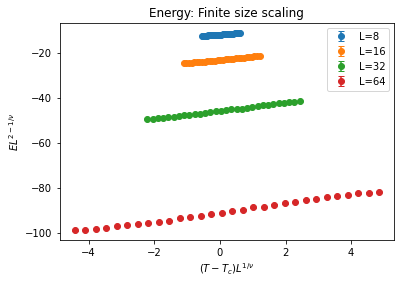

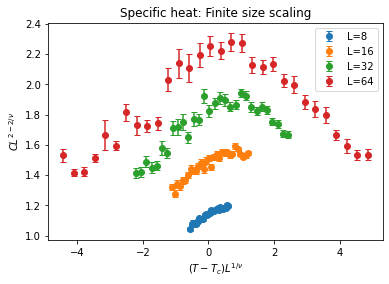

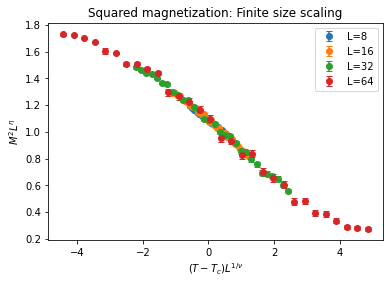

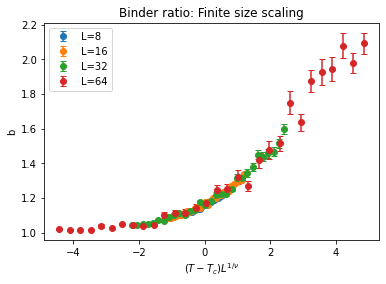

In [7]:
## scaling plot
pyplot.figure()
pyplot.title("Energy: Finite size scaling")
pyplot.xlabel("$(T-T_c)L^{1/\\nu}$")
pyplot.ylabel("$E L^{2-1/\\nu}$")
for i in range(len(L_list)):
    pyplot.errorbar(np.array(T_list_all[i]-Tc_est)*L_list[i]**(1/nu),np.array(Ene_all[i])*L_list[i]**(2.0-1.0/nu),yerr=np.array(Ene_err_all[i])*L_list[i]**(2.0-1.0/nu),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
pyplot.legend()

pyplot.figure()
pyplot.title("Specific heat: Finite size scaling")
pyplot.xlabel("$(T-T_c)L^{1/\\nu}$")
pyplot.ylabel("$C L^{2-2/\\nu}$")
for i in range(len(L_list)):
    pyplot.errorbar(np.array(T_list_all[i]-Tc_est)*L_list[i]**(1/nu),np.array(C_all[i])*L_list[i]**(2.0-2.0/nu),yerr=np.array(C_err_all[i])*L_list[i]**(2.0-2.0/nu),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
pyplot.legend()

pyplot.figure()
pyplot.title("Squared magnetization: Finite size scaling")
pyplot.xlabel("$(T-T_c)L^{1/\\nu}$")
pyplot.ylabel("$M^2L^{\eta}$")
for i in range(len(L_list)):
    pyplot.errorbar(np.array(T_list_all[i]-Tc_est)*L_list[i]**(1/nu),np.array(Mag2_all[i])*L_list[i]**(eta),yerr=np.array(Mag2_err_all[i])*L_list[i]**(eta),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
pyplot.legend()

if algorithm == "cluster":
    pyplot.figure()
    pyplot.title("Squared magnetization:improved: Finite size scaling")
    pyplot.xlabel("$(T-T_c)L^{1/\\nu}$")
    pyplot.ylabel("$M^2L^{\eta}$")
    for i in range(len(L_list)):
        pyplot.errorbar(np.array(T_list_all[i]-Tc_est)*L_list[i]**(1/nu),np.array(Mag2_imp_all[i])*L_list[i]**(eta),yerr=np.array(Mag2_imp_err_all[i])*L_list[i]**(eta),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
    pyplot.legend()

pyplot.figure()
pyplot.title("Binder ratio: Finite size scaling")
pyplot.xlabel("$(T-T_c)L^{1/\\nu}$")
pyplot.ylabel("b")
for i in range(len(L_list)):
    pyplot.errorbar(np.array(T_list_all[i]-Tc_est)*L_list[i]**(1/nu),np.array(Binder_all[i]),yerr=np.array(Binder_err_all[i]),capsize=3,fmt="o",label = "L="+repr(L_list[i]))
pyplot.legend()


pyplot.show()